### Introduction to Optimal Binning with `optbinning`
**Steps**

1. **Creating a Synthetic Dataset**: We'll start by generating a synthetic dataset to demonstrate the functionalities of `optbinnig.

2. **Configuration for Risk Drivers**: For each risk driver in our dataset, we will create a configuration file to guide the binning prcss.

3. **Creating Optimal Binnings**: Utilizing the configurations, we will apply the `optbinning` package to create optimal binnings for each vrable.

4. **Analyzing Binning Results**: We'll then look at general statistics for each variable and visualize the Weight of Evidence (WoE) graphs to understand the  binning!binning!


In [1]:
import pandas as pd
import numpy as np
from optbinning import BinningProcess
from sklearn.metrics import roc_auc_score
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from scipy.stats import chi2_contingency

# Options
pd.set_option('display.max_colwidth', None)

In [2]:
# Number of samples
n_samples = 1000

# Continuous risk drivers (e.g., age, income)
np.random.seed(0)
age = np.random.normal(35, 10, n_samples).clip(18, 100)
income = np.random.normal(50000, 15000, n_samples).clip(10000, 100000)

# Categorical risk drivers (e.g., employment type, marital status)
employment_types = ['employed', 'self-employed', 'unemployed', 'student']
marital_status = ['single', 'married', 'divorced', 'widowed']
employment = np.random.choice(employment_types, n_samples)
marital = np.random.choice(marital_status, n_samples)

# Assigning default probabilities based on categorical variables
employment_default_probs = {'employed': 0.05, 'self-employed': 0.1, 'unemployed': 0.2, 'student': 0.15}
marital_default_probs = {'single': 0.1, 'married': 0.05, 'divorced': 0.15, 'widowed': 0.08}

# Calculating default probability
default_probability = np.array([employment_default_probs[emp] for emp in employment]) + \
                      np.array([marital_default_probs[mar] for mar in marital]) + \
                      (age - 30) / 100 + (income - 50000) / 100000

# Binary target variable (e.g., default: yes/no)
default = (np.random.rand(n_samples) < default_probability).astype(int)

# Create DataFrame
data = pd.DataFrame({'Age': age, 'Income': income, 
                     'Employment': employment, 'MaritalStatus': marital, 
                     'Default': default})

# Introduce missing values
num_missing = int(len(data) * 0.1 / 100)
missing_indices = np.random.choice(data.index, num_missing, replace=False)
data.loc[missing_indices, 'Age'] = np.nan


data.head()

,Age,Income,Employment,MaritalStatus,Default
0,52.640523,58339.440196,self-employed,divorced,1
1,39.001572,63387.108310,student,widowed,0
2,44.787380,43665.277638,unemployed,single,0
3,57.408932,51570.710441,student,single,1
4,53.675580,53420.799877,unemployed,married,0


In [3]:
def gini_coefficient(data, var, target):
    """ Calculate the Gini coefficient for a variable using AUC.
        The function handles both continuous and categorical variables.
    """
    # Check if the variable is categorical
    df = data.dropna(subset=[var, target]).copy()
    
    if df[var].dtype == 'object':
        # Calculate the default rate for each category
        default_rates = df.groupby(var)[target].mean()
        y_scores = df[var].map(default_rates)
    else:
        # Use the variable as is for continuous variables
        y_scores = df[var]

    # Calculate AUC and then Gini coefficient
    auc = roc_auc_score(df[target], y_scores)
    return 2 * auc - 1


def binning_quality_score(iv, p_values, hhi_norm):
    # Score 1: Information value
    c = 0.39573882184806863
    score_1 = iv * np.exp(1/2 * (1 - (iv / c) ** 2)) / c

    # Score 2: statistical significance (pairwise p-values)
    p_values = np.asarray(p_values)
    score_2 = np.prod(1 - p_values)

    # Score 3: homogeneity
    score_3 = 1. - hhi_norm

    return score_1 * score_2 * score_3


def hhi(s, normalized=False):
    """Compute the Herfindahl–Hirschman Index (HHI).

    Parameters
    ----------
    s : array-like
        Fractions (exposure)

    normalized : bool (default=False)
        Whether to compute the normalized HHI.
    """
    s = np.asarray(s)
    h = np.sum(s ** 2)

    if normalized:
        n = len(s)
        if n == 1:
            return 1
        else:
            n1 = 1. / n
            return (h - n1) / (1 - n1)

    return h


def chi_square_test(df, column, target):
    """
    Performs a chi-square test to determine if the missingness in a given column is
    related to a binary target variable.

    Parameters:
    df (DataFrame): The pandas DataFrame containing your data.
    column (str): The name of the column to check for missingness.
    target (str): The name of the binary target variable.

    Returns:
    None: Prints the result of the chi-square test.
    """
    # Create a flag for missing values
    df['is_missing'] = df[column].isna()

    # Create a contingency table
    contingency_table = pd.crosstab(df['is_missing'], df[target])

    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Basic interpretation
    if p < 0.05:
        return "Informative missings", p
    else:
        return "Uninformative missings", p


In [4]:
# Create config table
optbinning_config = {
    'Age': {'dtype': 'numerical', 'min_n_bins': 3, 'max_n_bins': 5, 'max_pvalue': 0.05, 'monotonic_trend': 'auto_asc_desc'},
    'Income': {'dtype': 'numerical', 'min_n_bins': 3, 'max_n_bins': 5, 'max_pvalue': 0.05, 'monotonic_trend': 'auto_asc_desc'},
    'Employment': {'dtype': 'categorical', 'min_n_bins': 3, 'max_n_bins': 5, 'max_pvalue': 0.05, 'monotonic_trend': 'auto_asc_desc'},
    'MaritalStatus': {'dtype': 'categorical', 'min_n_bins': 3, 'max_n_bins': 5, 'max_pvalue': 0.05, 'monotonic_trend': 'auto_asc_desc'}
}

In [5]:
# Initialize BinningProcess and fit
binning_process = BinningProcess(variable_names=list(optbinning_config.keys()))
binning_process.fit(data.drop('Default', axis=1), data['Default'])
binned_data = binning_process.transform(data.drop('Default', axis=1), metric="woe")
binned_data.columns = [f'{col}_b' for col in binned_data.columns]

# Concatenate the original data with the binned data
data_with_binned = pd.concat([data, binned_data], axis=1)

# Create stats
summary_table = pd.DataFrame(columns=['Variable', 'BinningSummary'])
stats_df = pd.DataFrame()

for var in optbinning_config.keys():
    # Binning Table for the variable
    binning_obj = binning_process.get_binned_variable(var).binning_table
    binning_table = binning_obj.build()

    # Maximum shares
    filtered_data = binning_table[-binning_table['Bin'].isin(['Special', 'Missing'])][:-1]
    min_count_pct = filtered_data['Count (%)'].min()
    max_count_pct = filtered_data['Count (%)'].max()

    # stats
    iv = binning_table['IV'][:-1].sum()
    iv_no_missings = filtered_data['IV'].sum()
    gini = binning_obj.gini
    hhi_score = hhi(binning_table['Count (%)'][:-1], normalized=False)
    num_bins = len(binning_table)
    raw_gini = gini_coefficient(data, var, 'Default')
    missing_share = 2 #binning_table.loc[binning_table['Bin'] == 'Missing', 'Count (%)'].values[0]
    missings_type, p_chi_square = chi_square_test(data, var, 'Default')

    # Create a temporary DataFrame for this iteration
    temp_df = pd.DataFrame({
        'Variable': [var], 
        'Quality Score': binning_obj.quality_score,
        'IV': [iv], 
        'IV_no_missings': [iv_no_missings],
        'Gini': [gini], 
        'Raw Gini': [raw_gini],
        'HHI': [hhi_score], 
        'Num Bins': [num_bins], 
        'Largest Bin Share': [max_count_pct], 
        'Smallest Bin Share': [min_count_pct],
        'Share of missings': [missing_share],
        'Type of missings': [missings_type],
        'Missings chi_square': [p_chi_square],
    })

    # Concatenate with the main DataFrame
    stats_df = pd.concat([stats_df, temp_df], ignore_index=True)

In [6]:
pd.options.display.float_format = '{:,.2%}'.format
stats_df

,Variable,Quality Score,IV,IV_no_missings,Gini,Raw Gini,HHI,Num Bins,Largest Bin Share,Smallest Bin Share,Share of missings,Type of missings,Missings chi_square
0,Age,27.83%,29.20%,29.20%,27.98%,25.43%,23.54%,9,34.10%,6.00%,2,Uninformative missings,62.79%
1,Income,34.79%,55.62%,55.62%,37.05%,35.41%,16.46%,10,22.60%,5.20%,2,Uninformative missings,100.00%
2,Employment,0.09%,5.75%,5.75%,11.96%,11.96%,25.08%,7,26.90%,23.60%,2,Uninformative missings,100.00%
3,MaritalStatus,0.34%,1.69%,1.69%,6.87%,6.87%,25.04%,7,26.40%,23.80%,2,Uninformative missings,100.00%


In [7]:
binning_obj.analysis()

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.06874889
    IV (Jeffrey)             0.01686869
    JS (Jensen-Shannon)      0.00210534
    Hellinger                0.00210696
    Triangular               0.00840845
    KS                       0.05217408
    HHI                      0.25036000
    HHI (normalized)         0.10043200
    Cramer's V               0.05774459
    Quality score            0.00343089

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1      108.07%   29.85%    14.77%    85.23%
        1      2       16.79%   68.20%    34.10%    65.90%
        2      3        9.62%   75.65%    37.78%    62.22%



In [8]:
data_with_binned[['Age_b', 'Income_b', 'Employment_b', 'MaritalStatus_b']].corr()

,Age_b,Income_b,Employment_b,MaritalStatus_b
Age_b,100.00%,0.01%,1.83%,-4.02%
Income_b,0.01%,100.00%,-0.06%,3.11%
Employment_b,1.83%,-0.06%,100.00%,-7.17%
MaritalStatus_b,-4.02%,3.11%,-7.17%,100.00%


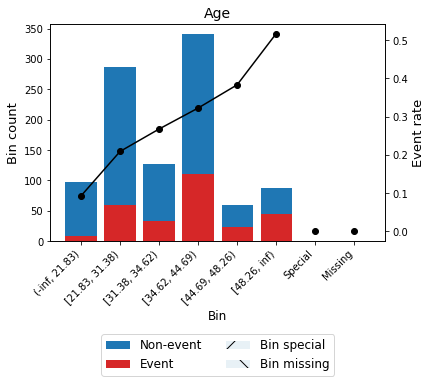

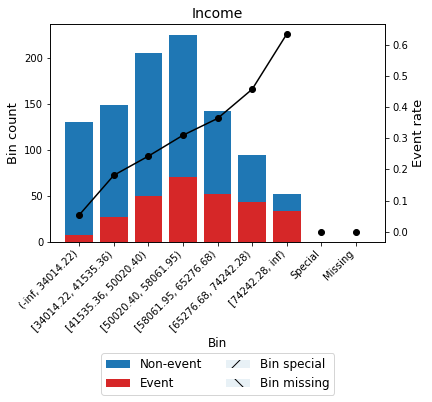

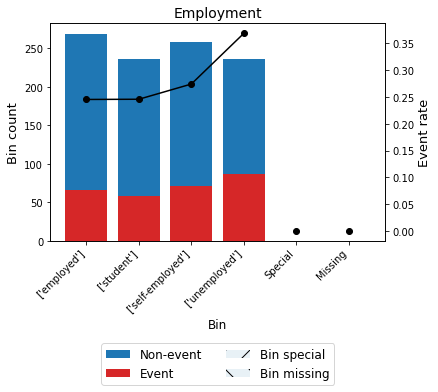

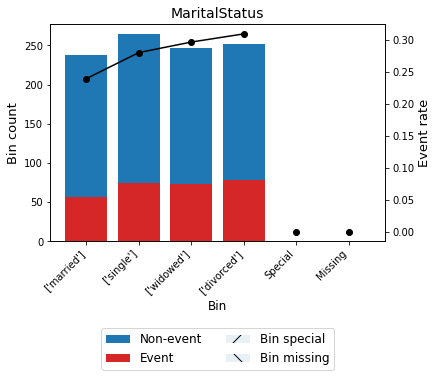

In [9]:
# Create charts
for var in optbinning_config.keys():
    # Binning Table for the variable
    binning_obj = binning_process.get_binned_variable(var).binning_table
    binning_obj.plot(metric="event_rate", show_bin_labels=True)

In [10]:
binning_obj.analysis()

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.06874889
    IV (Jeffrey)             0.01686869
    JS (Jensen-Shannon)      0.00210534
    Hellinger                0.00210696
    Triangular               0.00840845
    KS                       0.05217408
    HHI                      0.25036000
    HHI (normalized)         0.10043200
    Cramer's V               0.05774459
    Quality score            0.00343089

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1      108.07%   29.85%    14.77%    85.23%
        1      2       16.79%   68.20%    34.10%    65.90%
        2      3        9.62%   75.65%    37.78%    62.22%



In [11]:
binning_process.get_binned_variable(var).binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[married],238,23.80%,181,57,23.95%,22.09%,1.10%,0.14%
1,[single],264,26.40%,190,74,28.03%,0.84%,0.00%,0.00%
2,[widowed],246,24.60%,173,73,29.67%,-7.17%,0.13%,0.02%
3,[divorced],252,25.20%,174,78,30.95%,-13.22%,0.45%,0.06%
4,Special,0,0.00%,0,0,0.00%,0.00%,0.00%,0.00%
5,Missing,0,0.00%,0,0,0.00%,0.00%,0.00%,0.00%
Totals,,1000,100.00%,718,282,28.20%,,1.69%,0.21%


In [12]:
data_with_binned.head()

,Age,Income,Employment,MaritalStatus,Default,Age_b,Income_b,Employment_b,MaritalStatus_b
0,"5,264.05%","5,833,944.02%",self-employed,divorced,1,-100.36%,-37.49%,3.92%,-13.22%
1,"3,900.16%","6,338,710.83%",student,widowed,0,-19.26%,-37.49%,18.68%,-7.17%
2,"4,478.74%","4,366,527.76%",unemployed,single,0,-45.91%,20.33%,-39.65%,0.84%
3,"5,740.89%","5,157,071.04%",student,single,1,-100.36%,-13.32%,18.68%,0.84%
4,"5,367.56%","5,342,079.99%",unemployed,married,0,-100.36%,-13.32%,-39.65%,22.09%


In [13]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

def calculate_feature_importances(X, y):
    """
    Calculates and standardizes feature importances using several methods including
    permutation importance, SHAP values, WoE coefficients, and Gini comparison.

    Parameters:
    X (DataFrame): A pandas DataFrame containing the risk drivers.
    y (Series): A pandas Series containing the target variable.

    Returns:
    DataFrame: A DataFrame containing features and their standardized importances.
    """

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fit the logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Permutation Importance
    results = permutation_importance(model, X_test, y_test, scoring='roc_auc')
    permutation_importance_vals = results.importances_mean
    permutation_importance_normalized = permutation_importance_vals / permutation_importance_vals.sum()

    # SHAP Values
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)
    shap_sum = np.abs(shap_values.values).mean(axis=0)
    shap_importance_normalized = shap_sum / shap_sum.sum()

    # Standardized WoE Coefficients
    woe_coefficients = model.coef_[0]
    woe_coefficients_normalized = np.abs(woe_coefficients) / np.abs(woe_coefficients).sum()

    # Aggregate the results
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'permutation_importance': permutation_importance_normalized,
        'shap_importance': shap_importance_normalized,
        'woe_coefficient': woe_coefficients_normalized,
    })

    return feature_importance

# Usage example
cols = ['Age_b', 'Income_b', 'Employment_b', 'MaritalStatus_b']
feature_importances = calculate_feature_importances(data_with_binned[cols], data_with_binned['Default'])
feature_importances

,feature,permutation_importance,shap_importance,woe_coefficient
0,Age_b,30.23%,35.60%,29.05%
1,Income_b,56.92%,44.19%,25.65%
2,Employment_b,10.73%,14.88%,27.53%
3,MaritalStatus_b,2.11%,5.32%,17.77%
